In [23]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0,os.path.dirname(os.path.dirname(currentdir)))

from mlopt.mlopt.timeseries.AGMLP_Residual import AGMLP_Residual
from mlopt.mlopt.timeseries.AGMLP_Residual import AGMLP_VR_Residual
from mlopt.mlopt.timeseries.TimeSeriesUtils import *
import copy

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Process Data

In [25]:
inmet_csv = './historical_data_BOMJESUSDALAPA.csv'
save_scaler = "bomjesusdalapa_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 30*24

posicao_final=len(df_inmet)-1
posicao_inicial=posicao_final - ultimos_dias

df_inmet = df_inmet.iloc[posicao_inicial:,:]

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[:].values.reshape(-1,1)

print("data hora inicial: ", df_inmet.iloc[0,:].data, df_inmet.iloc[0,:].hora,
      "data hora final: ", df_inmet.iloc[-1,:].data,df_inmet.iloc[-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open(save_scaler, 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
data hora inicial:  2020/07/01 23 data ho

# SARIMAX 

## Auto ARIMA

In [5]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-92.428, Time=0.50 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-807.455, Time=3.87 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-545.838, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-60.479, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-650.212, Time=0.43 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-737.426, Time=3.36 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=15.27 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-806.461, Time=4.53 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=-805.127, Time=4.65 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=-714.022, Time=3.74 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=-

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 24),
      suppress_warnings=True, with_intercept=False)

In [5]:
mod = SARIMAX(endog=gen, exog=exog, order=(3, 0, 2), seasonal_order=(2, 0, 2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(gen, y_sarimax_auto, threshold=0.1)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -825.1780321053784, Mape: 14.518292069655189


## PSO-ACO Parametrization

In [7]:
p = [0, 1, 2, 3, 4]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2, 3]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
exogColumns = ['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt', 'vento_velocidade_mps', 'vento_rajada_max_mps']
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, exogColumns=exogColumns, verbose=False)
                                   
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-02-09 23:08:28,838 - root - INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,838: INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,841 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,841: INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,843 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,843: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,845 - root - INFO - 5
2021-02-09 23:08:28,845: INFO - 5
2021-02-09 23:08:29,424 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 

In [6]:
mod = SARIMAX(endog=gen, exog=exog[:,[1,2,3]], order=(1,0,0), seasonal_order=(2,0,2,24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(gen, y_sarimax_PSO_ACO_hand, threshold=0.1)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -831.7993711365862, Mape: 14.82008523690549


## DUMP Sarimax

In [11]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

In [43]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

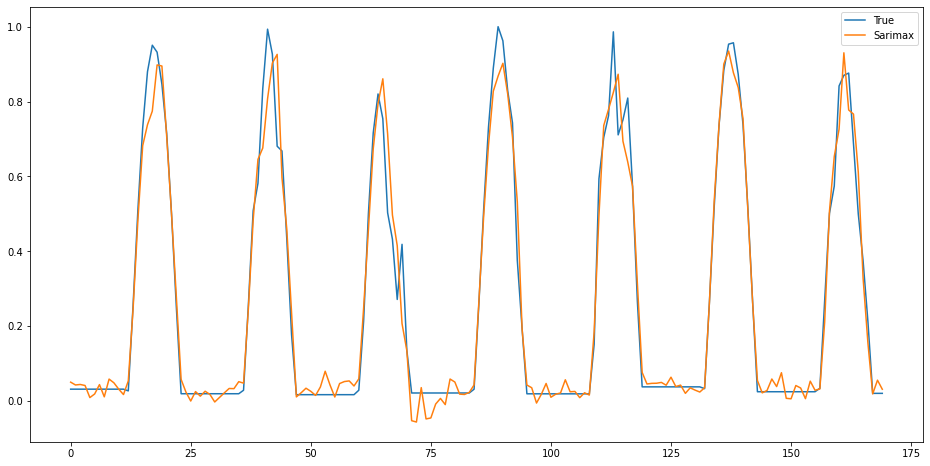

In [7]:
plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
# pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

| 3/4 [00:22<00:07,  7.59s/it]
100%|██████████| 4/4 [00:27<00:00,  6.96s/it]

100%|██████████| 4/4 [00:19<00:00,  4.99s/it]

100%|██████████| 4/4 [01:19<00:00, 19.81s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

100%|██████████| 4/4 [00:47<00:00, 12.00s/it]

100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

100%|██████████| 4/4 [00:53<00:00, 13.38s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

100%|██████████| 4/4 [00:22<00:00,  5.69s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

 25%|██▌       | 1/4 [17:22<52:06, 1042.02s/it]generation: 1

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

100%|██████████| 4/4 [00:47<00:00, 11.98s/it]

100%|██████████| 4/4 [00:13<00:00,  3.47s/it]

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

100%|█████████

## Análise Resultados

In [44]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best_mlp_residual = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best_mlp_residual[0],
                                                                                            tr_ts_percents)
erro_estimado = np.concatenate((best_mlp_residual[4].predict(erro_train_entrada),
                                best_mlp_residual[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best_mlp_residual[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best_mlp_residual[2],
                                                                best_mlp_residual[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best_mlp_residual[5].predict(X_in_train), best_mlp_residual[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best_mlp_residual[5].predict(X_in_test)

len_dt = len(data_test)

print(best_mlp_residual)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test,
                                                                        data_test),best_mlp_residual[6]))
print (mae(y_estimado_so_test, data_test) ==  best_mlp_residual[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(data_test[-len_dt:], y_sarimax[-len_dt:]))
print('MSE: ', mse(data_test[-len_dt:], y_sarimax[-len_dt:]))
print('MAPE: ', MAPE(data_test[-len_dt:], y_sarimax[-len_dt:], threshold=0.1))
print('HIBRIDO')
print('MAE: ', mae(data_test[-len_dt:], y_estimado_so_test[-len_dt:]))
print('MSE: ', mse(data_test[-len_dt:], y_estimado_so_test[-len_dt:]))
print('MAPE: ', MAPE(data_test[-len_dt:], y_estimado_so_test[-len_dt:], threshold=0.1))

# plt.figure(figsize=(18,9), dpi=300)
# plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
# plt.plot(gen[-len_dt:], 'r', label='real')
# plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
# plt.grid(axis='x')
# plt.legend()

[7, 15, 12, 8, MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(66, 3, 1), learning_rate='invscaling',
             max_iter=500, solver='lbfgs'), MLPRegressor(early_stopping=True, hidden_layer_sizes=(22, 44, 9), max_iter=500,
             solver='lbfgs'), 0.031054650812002642]
Teste para saber se pegou o melhor mesmo! 0.031054650812002687 == 0.031054650812002642 ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  9.856800737076211
HIBRIDO
MAE:  0.031054650812002687
MSE:  0.003046259939783726
MAPE:  12.013943037597015


In [ ]:
np.savetxt("resultados/arrays/agmlp_residual.txt",y_estimado_so_test)

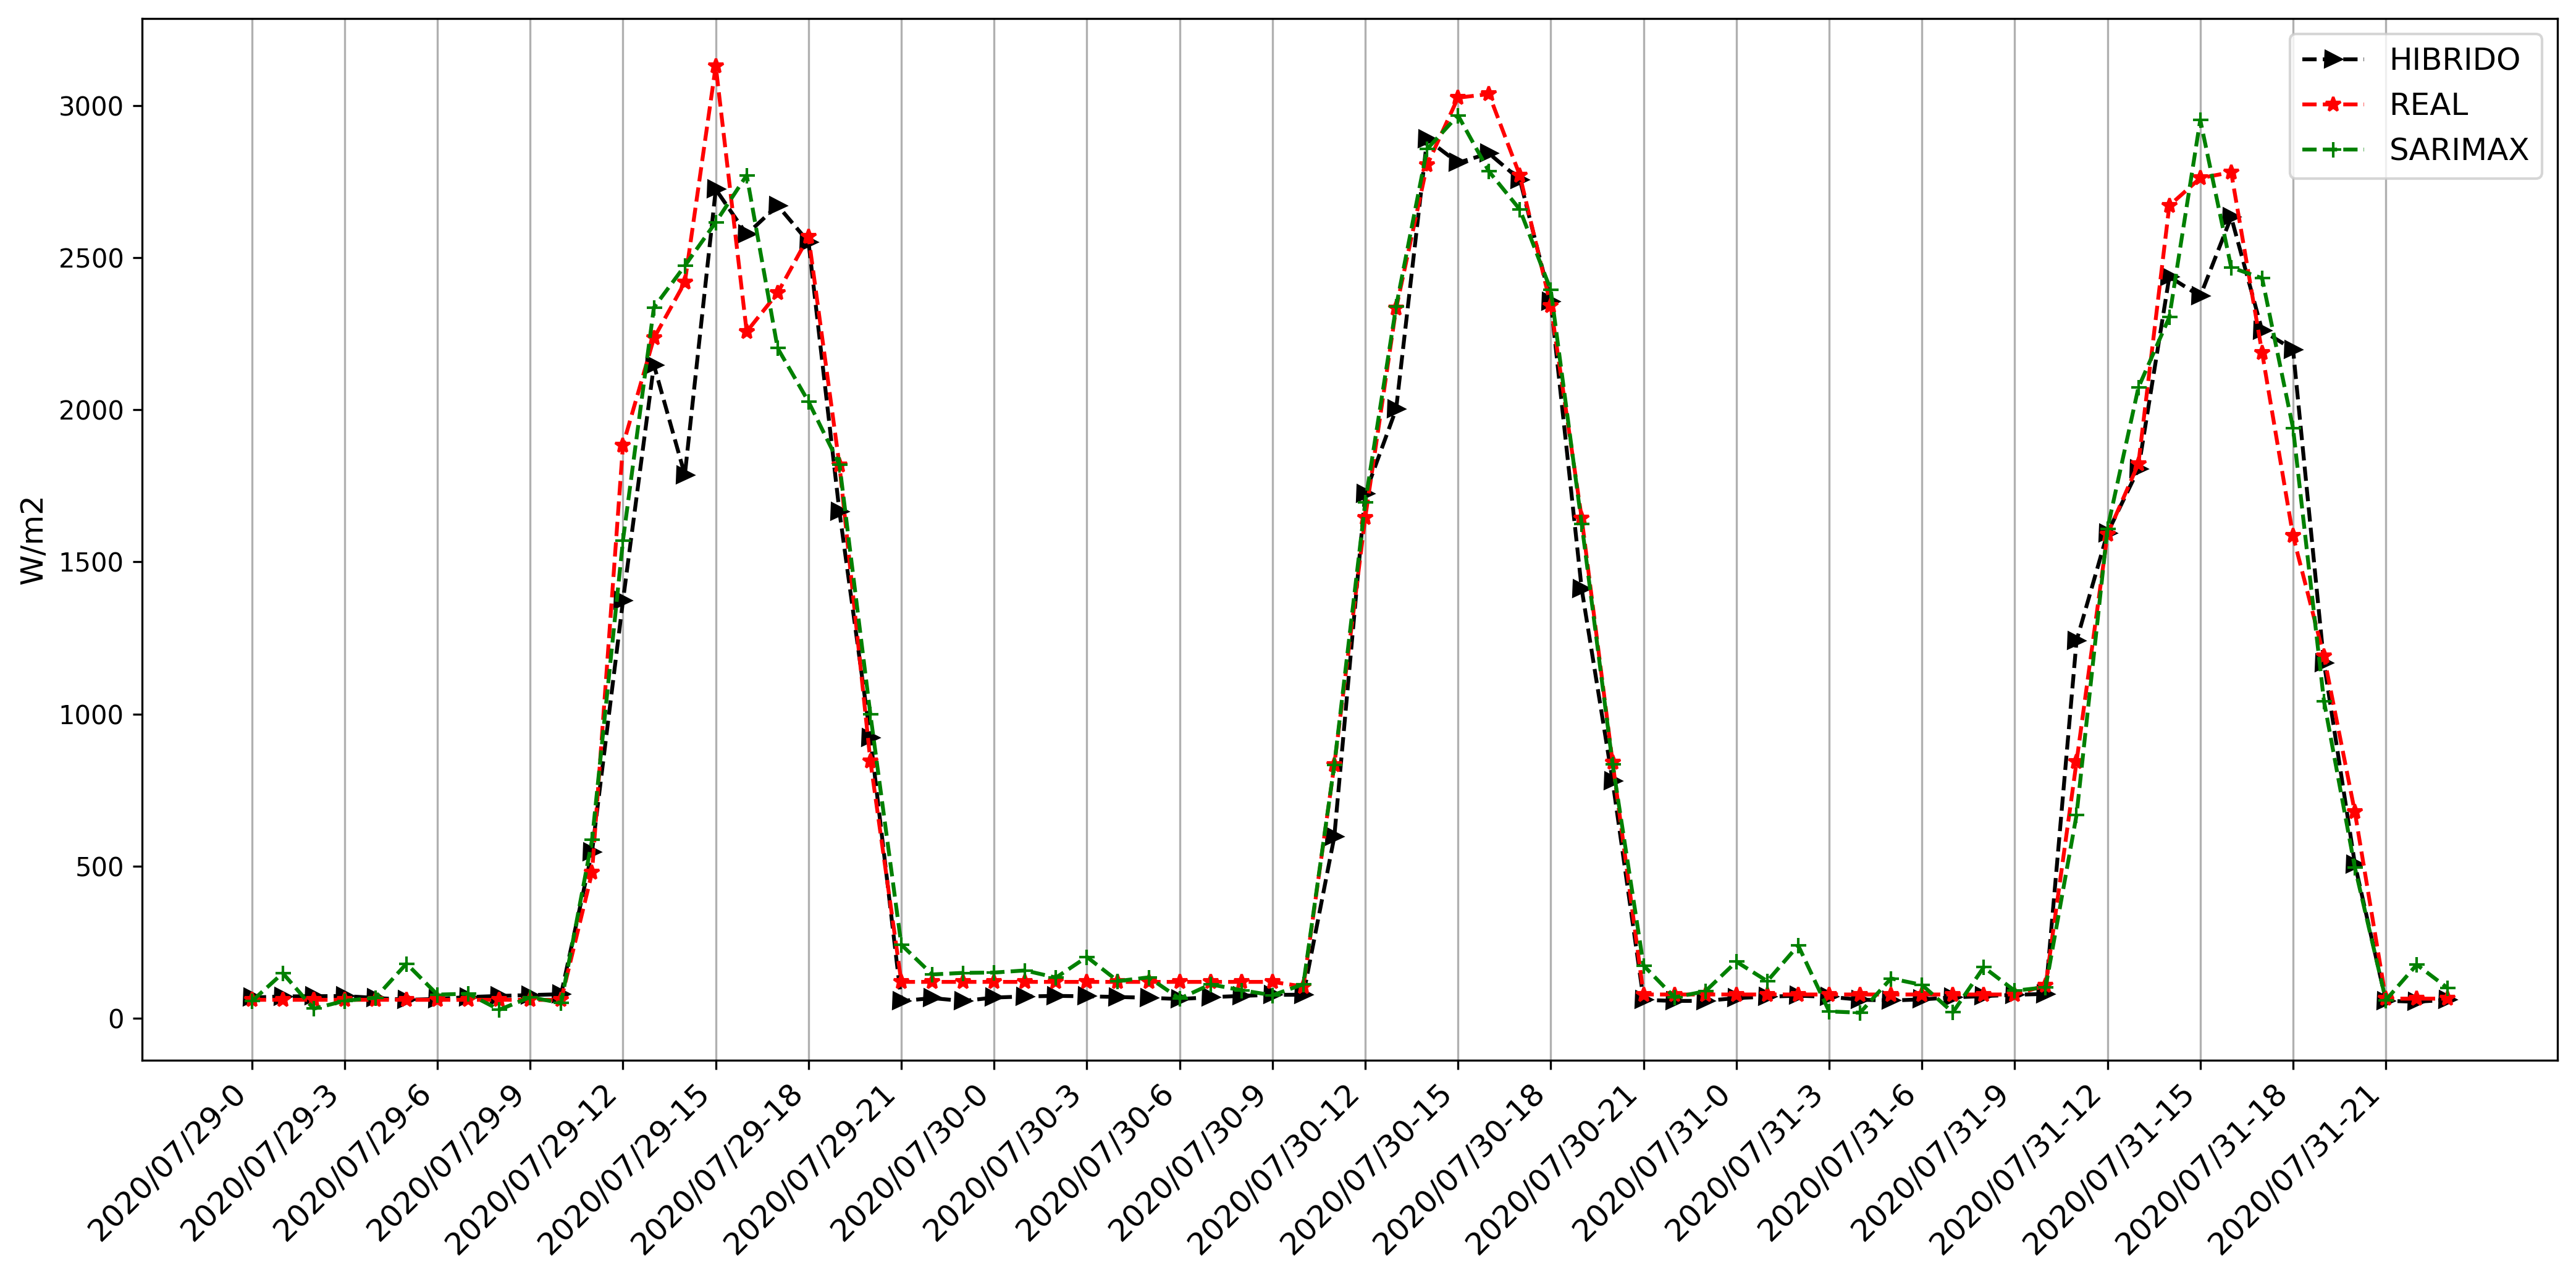

In [10]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch4_pop15.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

## Train

In [ ]:
tr_ts_percents=[80,20]

In [5]:
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15,
                                       prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0


  0%|          | 0/4 [00:00<?, ?it/s]

generation: 0
start_set_fit: 0


 25%|██▌       | 1/4 [14:10<42:32, 850.92s/it]

generation: 1
start_set_fit: 1


 50%|█████     | 2/4 [25:27<24:56, 748.22s/it]

generation: 2
start_set_fit: 3


 75%|███████▌  | 3/4 [34:07<10:44, 644.35s/it]

generation: 3
start_set_fit: 5


100%|██████████| 4/4 [42:21<00:00, 635.46s/it]


## Análise Resultados

[4, 18, 17, 5, 81, <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x000002458023A760>, <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x00000245802CB4C0>, 0.02877514507570178]
Teste para saber se pegou o melhor mesmo! 0.02877514507570178 == <mlopt.mlopt.omodels.AgMlp.AgMlp object at 0x00000245802CB4C0> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  9.856800737076211
HIBRIDO
MAE:  0.02877514507570178
MSE:  0.0023840311989399335
MAPE:  9.879931438624425


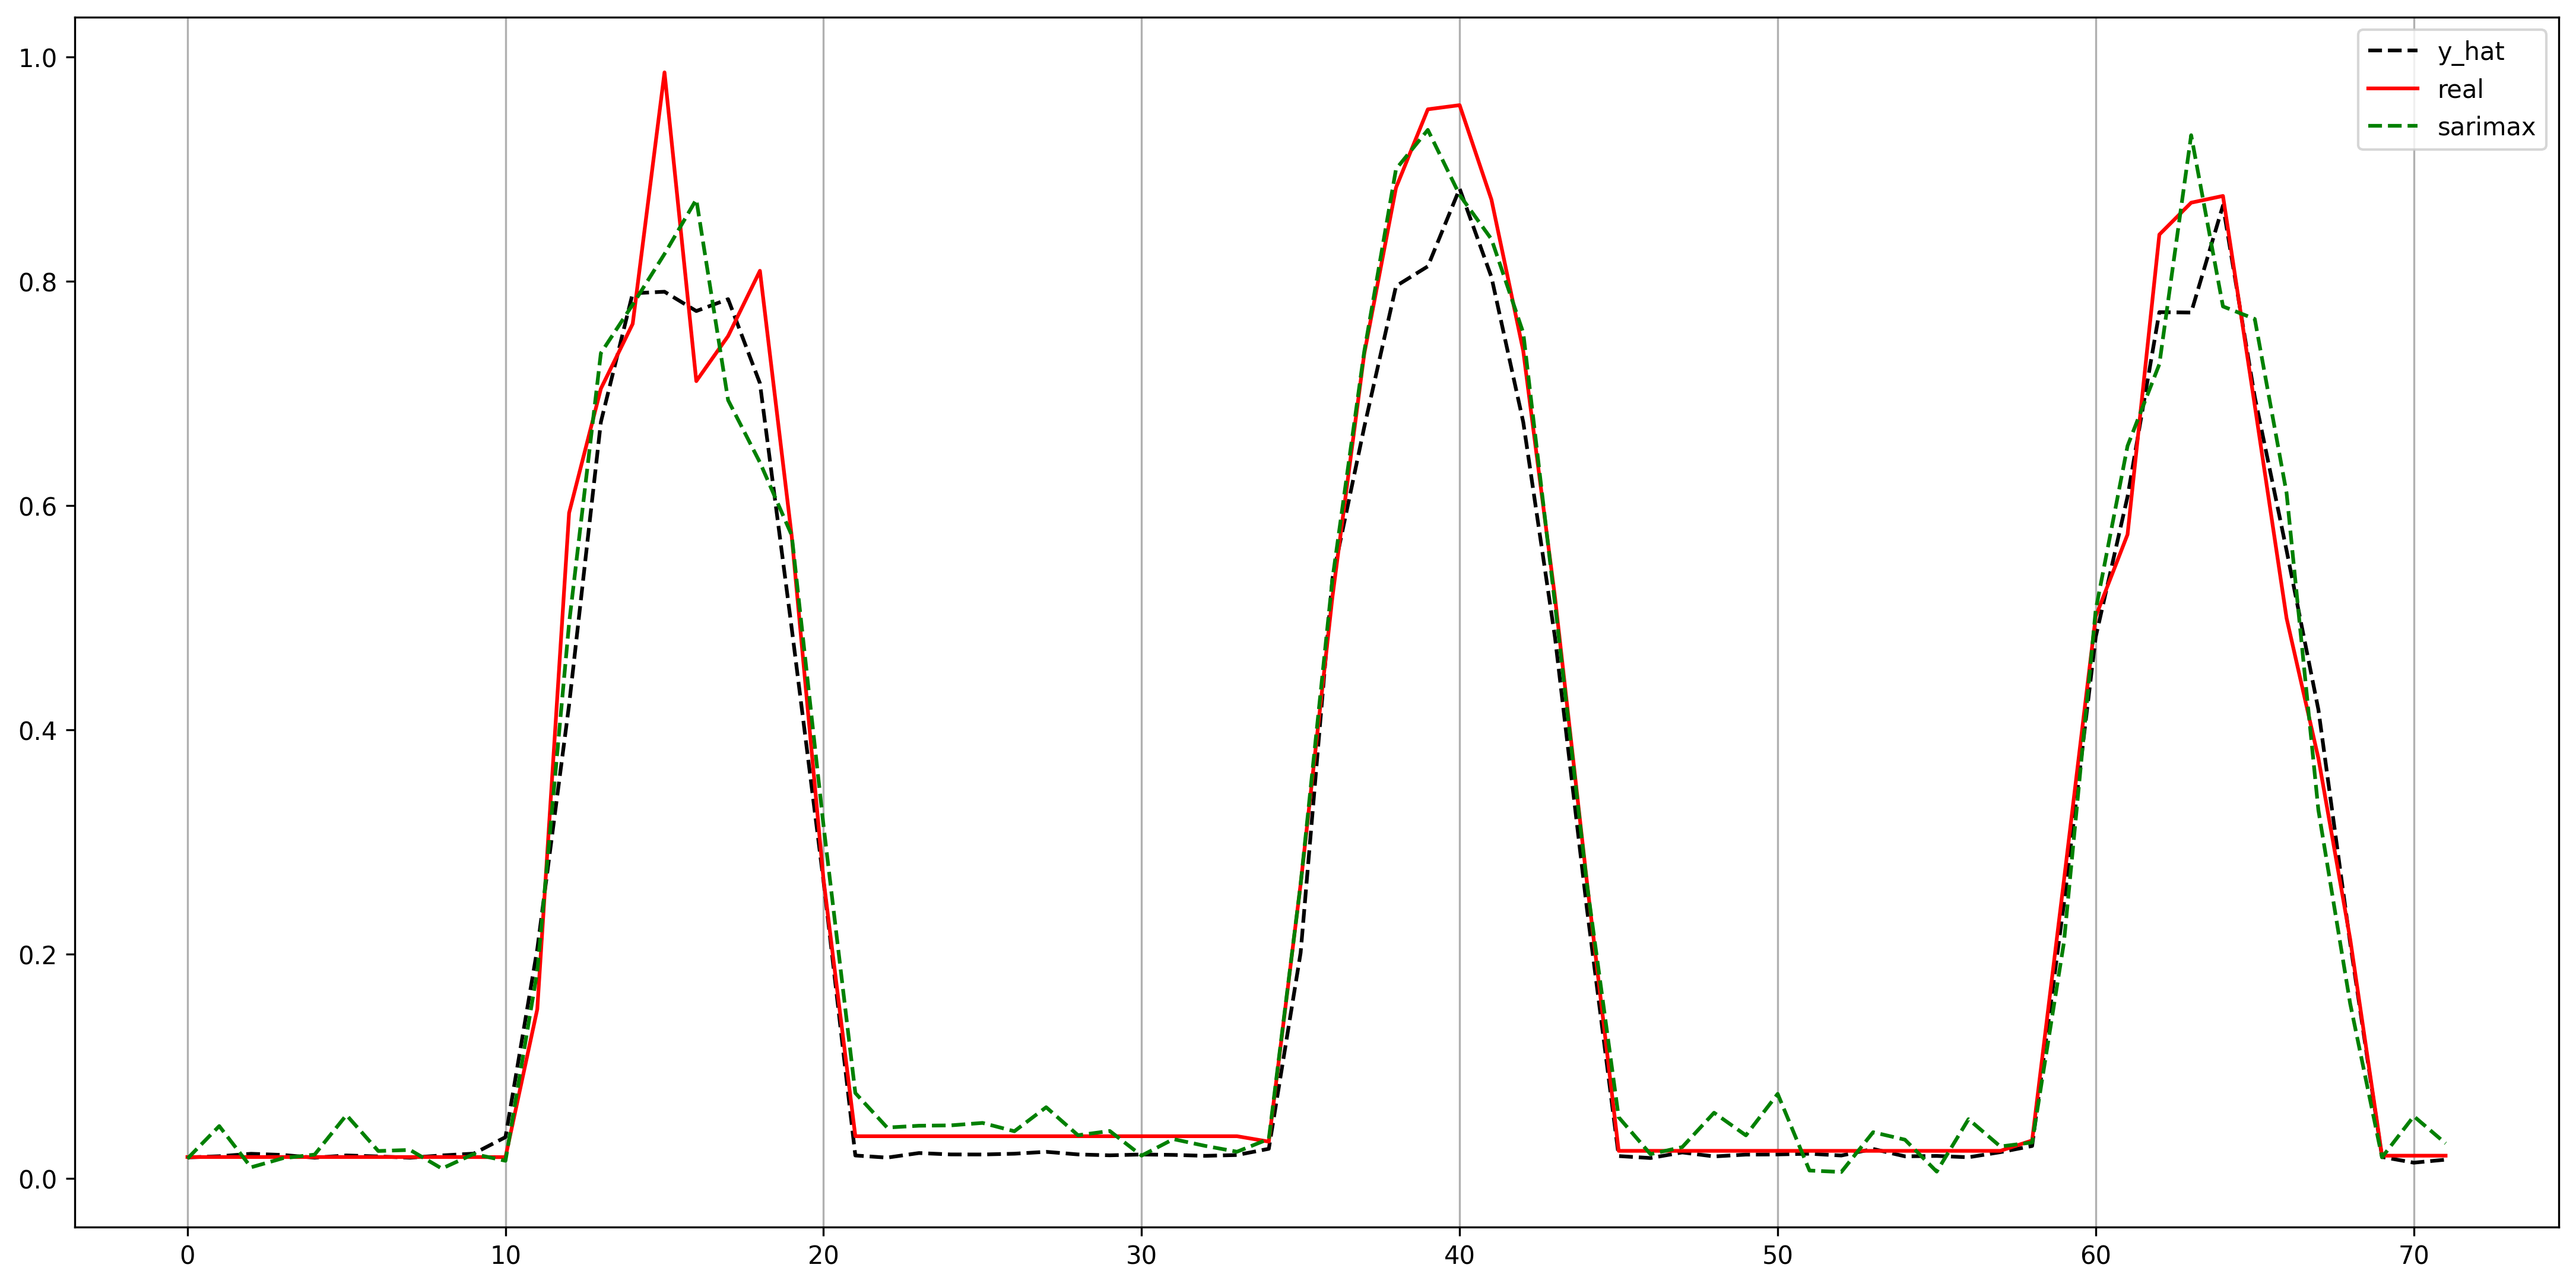

In [11]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(data_test[-len_dt:], y_sarimax[-len_dt:]))
print('MSE: ', mse(data_test[-len_dt:], y_sarimax[-len_dt:]))
print('MAPE: ', MAPE(data_test[-len_dt:], y_sarimax[-len_dt:], threshold=0.1))
print('HIBRIDO')
print('MAE: ', mae(data_test[-len_dt:], y_estimado_so_test[-len_dt:]))
print('MSE: ', mse(data_test[-len_dt:], y_estimado_so_test[-len_dt:]))
print('MAPE: ', MAPE(data_test[-len_dt:], y_estimado_so_test[-len_dt:], threshold=0.1))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

In [7]:
np.savetxt("resultados/arrays/agmlp_ensemble_residual.txt",y_estimado_so_test)

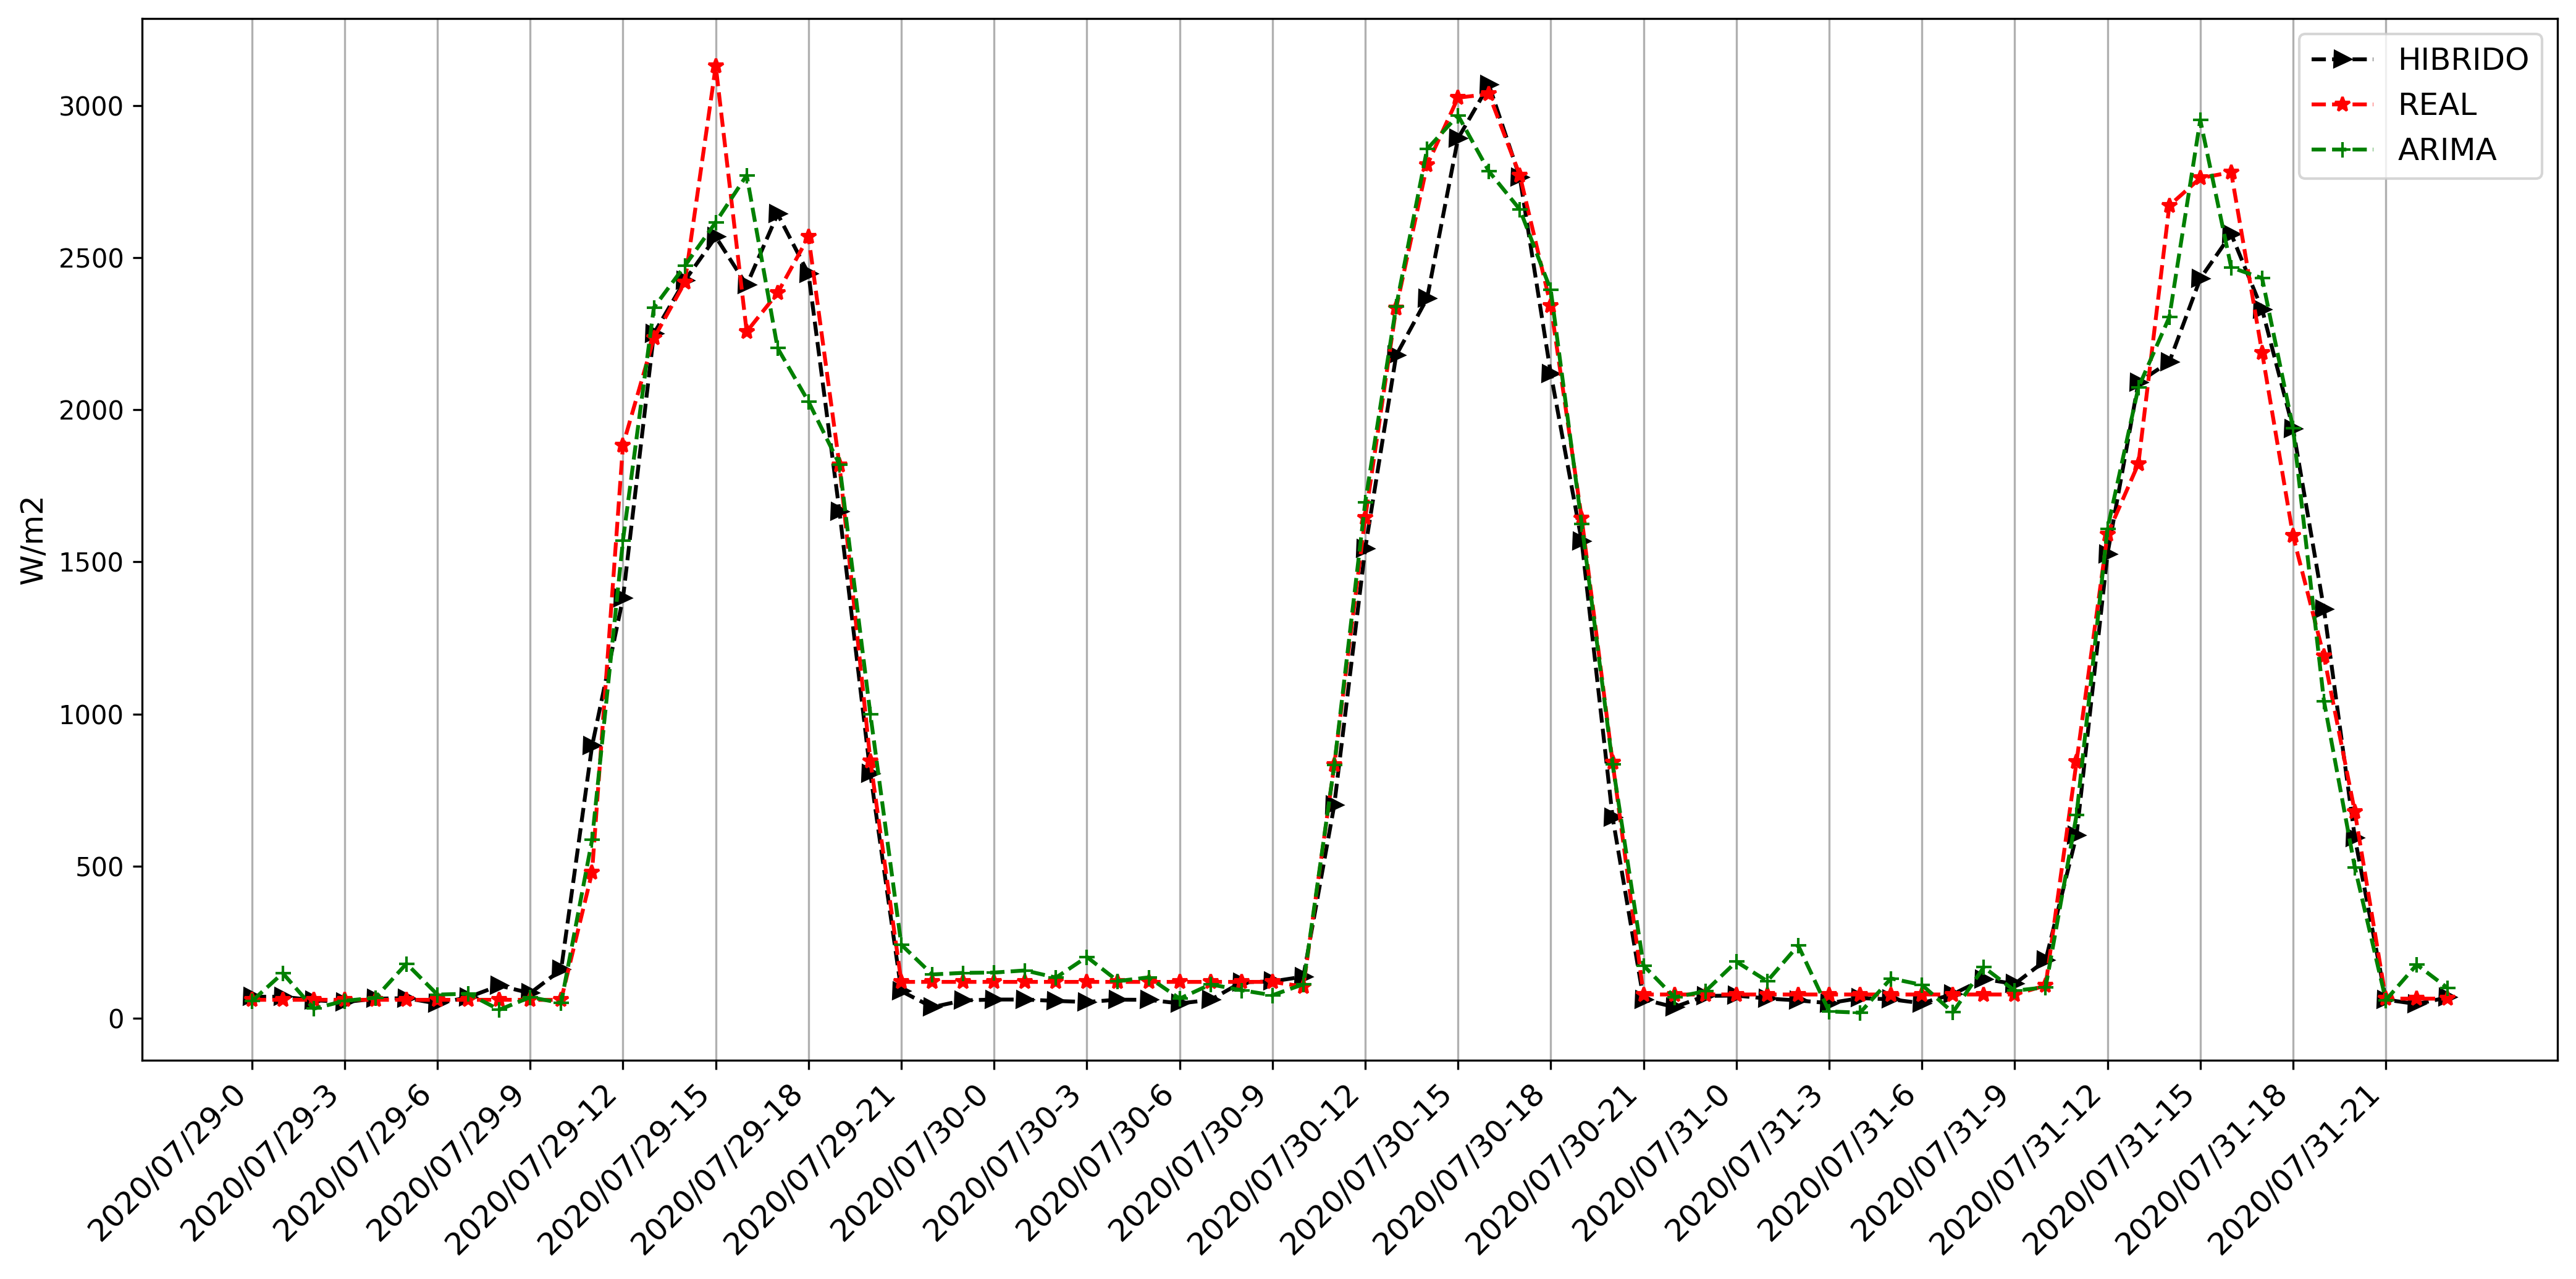

In [13]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/florianopolis_agmlpvrresidual_epoch4_pop15.png', dpi=300)

# LSTM

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [8]:
# from mlopt.mlopt.omodels.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

# options_ACO={'antNumber':3, 'antTours':2, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
# fl_qtn = [10, 30, 70, 100]
# fl_func = list(range(6))             
# sl_qtn = [5, 10, 20, 40]
# sl_func = list(range(6))
# tl_qtn = [1, 10, 15]
# tl_func = list(range(6))
# optimizer = list(range(4))
# epochs = list(range(3))
# searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
# X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
#                                                                         tr_vd_ts_percents = [80, 20],
#                                                                         print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [12]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm,1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

  0%|          | 0/2 [00:00<?, ?it/s]

2021-03-30 00:59:16,953 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:16,953: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 00:59:17,041 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:17,041: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,354 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:02:35,354: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:02:35,416 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,416: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,527 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,527: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:27,865 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:05:27,865: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:05:27,913 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:27,913: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:28,237 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:28,237: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,108 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:12:00,108: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:12:00,223 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,223: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,323 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,323: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,400 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:16:18,400: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:16:18,489 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,489: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,696 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,696: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:42,877 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:22:42,877: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:22:42,963 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:42,963: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:43,404 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:43,404: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:56,615 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:28:56,615: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:28:58,430 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,430: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:58,631 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,631: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,347 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:35:30,347: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:35:30,425 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,425: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,538 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,538: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,462 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:41:31,462: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:41:31,560 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,560: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,653 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,653: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,477 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:43:45,477: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:43:45,599 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,599: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,687 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,687: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,454 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:45:51,454: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:45:51,549 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,549: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,652 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,652: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,514 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:47:56,514: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:47:56,619 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,619: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,974 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,974: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,168 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:51:32,168: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

ACO-All Best Response: [30  2 10  4 10  4  1  2]. Fitness: 0.045856797266949134



2021-03-30 01:51:32,283 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,283: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,385 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,385: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:57:24,542 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:57:24,542: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive numbe

In [17]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-30 09:17:58,576 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-30 09:17:58,576: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [20]:
from tensorflow import keras

_, _, X_test_lstm, y_test_lstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)

loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_test_lstm, y_hat_lstm))
print('MSE: ', mse(y_test_lstm, y_hat_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm, threshold=0.1))

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


2021-10-22 23:49:55,095 - tensorflow - WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-10-22 23:49:55,095: WARNING - SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.
2021-10-22 23:49:55,107 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:49:55,107: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when runn

Resultado Dados Teste!
LSTM
MAE:  0.0427739069937352
MSE:  0.006897471314709104
MAPE:  16.670604028176456


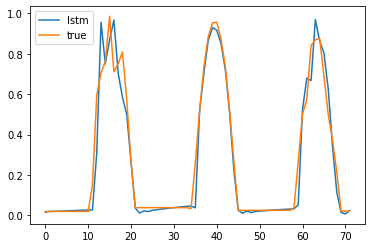

In [21]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

In [22]:
np.savetxt("resultados/arrays/lstm.txt",y_hat_lstm)

# CLSTM

## Train

In [13]:
from mlopt.mlopt.omodels.ACOLSTM import ACOCLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':3, 'antTours':3, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [14]:
Layers_Qtd=[[50, 30, 20, 10], [20, 15, 10], [10, 20], [30, 20], [10, 5]]
ConvKernels=[[8, 12], [4, 6]]
epochs=[200]

clstmOptimizer = ACOCLSTM(X_train_clstm, y_train_clstm, X_test_clstm, y_test_clstm,
                          1 ,options_ACO=options_ACO, verbose=True)

final_model, y_hat_clstm = clstmOptimizer.optimize(Layers_Qtd = Layers_Qtd, ConvKernels = ConvKernels, epochs=epochs)

  0%|          | 0/3 [00:00<?, ?it/s]2021-10-22 23:23:12,897 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:12,897: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:12,902 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:12,902: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


dimentions Ranges passed:  [[50, 30, 20, 10], [8, 12], [20, 15, 10], [4, 6], [10, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [30, 20], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [10, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3], [0]]
Space Created:  [[50  8 20 ...  0  0  0]
 [50  8 20 ...  0  1  0]
 [50  8 20 ...  0  2  0]
 ...
 [10 12 10 ...  5  1  0]
 [10 12 10 ...  5  2  0]
 [10 12 10 ...  5  3  0]]
number of Space Possibilities (rows):  11943936
Setting fitness for
[30  8 20  4 20  3  4 20  2  4 10  2  3  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'relu', 'fl_refunc': 'linear', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'linear', 'tl_qtn': 10, 'tl_func': 'tanh', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 3s 153ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 2s 189ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==========================

2021-10-22 23:23:23,392 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:23,392: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:23,399 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:23:23,399: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
1000
Setting fitness for
[50 12 15  4 10  2  2 20  1  0 10  5  0  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'tanh', 'fl_refunc': 'tanh', 'sl_qtn': 20, 'sl_func': 'selu', 'sl_refunc': 'elu', 'tl_qtn': 10, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
9/9 [==============================] - 4s 178ms/step - loss: 0.4187 - mse: 0.2174
Epoch 2/200
9/9 [==============================] - 2s 178ms/step - loss: 0.2576 - mse: 0.0888
Epoch 3/200
9/9 [==============================] - 1s 146ms/step - loss: 0.2099 - mse: 0.0644
Epoch 4/200
9/9 [==============================] - 1s 140ms/step - loss: 0.1612 - mse: 0.0455
Epoch 5/200
9/9 [==============================] - 1s 152ms/step - loss: 0.1396 - mse: 0.0328
Epoch 6/200
9/9 [==============================] - 1s 165ms/step - loss: 0.1344 - mse: 0.0300
Epoch 7/200
9/9 [==============================] - 1s 152ms/step - loss: 0.1270 - mse: 0.

2021-10-22 23:24:05,779 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:05,779: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:05,794 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:05,794: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[50  8 10  6 20  3  3 30  2  4 10  0  1  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'relu', 'fl_refunc': 'relu', 'sl_qtn': 30, 'sl_func': 'tanh', 'sl_refunc': 'linear', 'tl_qtn': 10, 'tl_func': 'elu', 'optimizer': 'adam'}
Epoch 1/200
9/9 [==============================] - 3s 135ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 142ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 155ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 143ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 140ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 23, 50)         

2021-10-22 23:24:14,995 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:14,995: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:15,010 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:15,010: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
1000
Setting fitness for
[50  8 15  6 10  5  0 30  4  4  5  4  2  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 10, 'fl_func': 'sigmoid', 'fl_refunc': 'elu', 'sl_qtn': 30, 'sl_func': 'linear', 'sl_refunc': 'linear', 'tl_qtn': 5, 'tl_func': 'linear', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 3s 152ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 152ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 141ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 146ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 145ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)          

2021-10-22 23:24:25,433 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:25,433: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:25,437 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:25,437: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[30  8 20  6 20  5  3 30  0  5 10  1  2  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'relu', 'sl_qtn': 30, 'sl_func': 'elu', 'sl_refunc': 'sigmoid', 'tl_qtn': 10, 'tl_func': 'selu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 4s 148ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 141ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 141ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 143ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 155ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 23, 30)  

2021-10-22 23:24:35,063 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:35,063: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:35,078 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:35,078: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
1000
Setting fitness for
[30  8 15  6 10  2  0 20  4  1 10  5  3  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 10, 'fl_func': 'tanh', 'fl_refunc': 'elu', 'sl_qtn': 20, 'sl_func': 'linear', 'sl_refunc': 'selu', 'tl_qtn': 10, 'tl_func': 'sigmoid', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 3s 151ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 139ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 144ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 138ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 140ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)             

 33%|███▎      | 1/3 [01:32<03:05, 92.93s/it]2021-10-22 23:24:45,825 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:45,825: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:45,830 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:24:45,830: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Ant 2 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 2 move from 3473526 to 1972262
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[6.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [0.5]
 [0.5]]
Pij:
[[1.3113591e-06]
 [1.0087378e-07]
 [1.0087378e-07]
 ...
 [1.0087378e-07]
 [1.0087378e-07]
 [1.0087378e-07]]
Ants now - then
[1544570 8479711 1972262] - [3188939 1441921 3473526]
Setting fitness for
[50 12 20  4 10  2  2 20  5  0  5  0  2  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'tanh', 'fl_refunc': 'tanh', 'sl_qtn': 20, 'sl_func': 'sigmoid', 'sl_refunc': 'elu', 'tl_qtn': 5, 'tl_func': 'elu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 4s 159ms/step - loss: 0.2190 - mse: 0.0798
Epoch 2/200
9/9 [==============================] - 1s 148ms/step - loss: 0.1603 - mse: 0.0407
Epoch 3/200
9/9 [==============================] - 1s 147ms/step - loss: 0.150

2021-10-22 23:25:18,919 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:18,919: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:18,924 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:18,924: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
0.13452221876807316
Setting fitness for
[50 12 15  6 20  5  2 20  1  2 10  2  3  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'tanh', 'sl_qtn': 20, 'sl_func': 'selu', 'sl_refunc': 'tanh', 'tl_qtn': 10, 'tl_func': 'tanh', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 3s 155ms/step - loss: 0.3753 - mse: 0.2273
Epoch 2/200
9/9 [==============================] - 1s 142ms/step - loss: 0.3153 - mse: 0.1540
Epoch 3/200
9/9 [==============================] - 1s 145ms/step - loss: 0.3197 - mse: 0.1598
Epoch 4/200
9/9 [==============================] - 1s 135ms/step - loss: 0.2987 - mse: 0.1357
Epoch 5/200
9/9 [==============================] - 1s 141ms/step - loss: 0.2566 - mse: 0.1046
Epoch 6/200
9/9 [==============================] - 1s 140ms/step - loss: 0.2570 - mse: 0.1060
Epoch 7/200
9/9 [==============================] - 1s 140ms/step - lo

2021-10-22 23:25:56,637 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:56,637: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:56,637 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:25:56,637: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[20 12 10  4 10  0  5 20  1  2  5  1  3  0]
{'conv_fl_filters_qtn': 20, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 20, 'sl_func': 'selu', 'sl_refunc': 'tanh', 'tl_qtn': 5, 'tl_func': 'selu', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 4s 184ms/step - loss: 0.4173 - mse: 0.2754
Epoch 2/200
9/9 [==============================] - 2s 278ms/step - loss: 0.3158 - mse: 0.1560
Epoch 3/200
9/9 [==============================] - 2s 244ms/step - loss: 0.2496 - mse: 0.0992
Epoch 4/200
9/9 [==============================] - 2s 272ms/step - loss: 0.2153 - mse: 0.0725
Epoch 5/200
9/9 [==============================] - 2s 229ms/step - loss: 0.2022 - mse: 0.0662
Epoch 6/200
9/9 [==============================] - 2s 269ms/step - loss: 0.2093 - mse: 0.0688
Epoch 7/200
9/9 [==============================] - 2s 262ms/step - loss: 0.1909 - mse: 0.0610
Epoch 8/

2021-10-22 23:27:00,841 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:00,841: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:00,841 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:00,841: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
0.11758635273064286
Setting fitness for
[20 12 15  4 10  1  3 30  3  5 10  1  3  0]
{'conv_fl_filters_qtn': 20, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'selu', 'fl_refunc': 'relu', 'sl_qtn': 30, 'sl_func': 'relu', 'sl_refunc': 'sigmoid', 'tl_qtn': 10, 'tl_func': 'selu', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 3s 160ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 156ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 165ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 154ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 142ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1

2021-10-22 23:27:11,418 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:11,418: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:11,422 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:11,422: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[50 12 20  6 20  5  0 20  2  0  5  3  2  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'elu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'elu', 'tl_qtn': 5, 'tl_func': 'relu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 4s 167ms/step - loss: 0.3684 - mse: 0.2598
Epoch 2/200
9/9 [==============================] - 1s 160ms/step - loss: 0.2240 - mse: 0.1022
Epoch 3/200
9/9 [==============================] - 1s 148ms/step - loss: 0.1795 - mse: 0.0641
Epoch 4/200
9/9 [==============================] - 1s 141ms/step - loss: 0.1153 - mse: 0.0327
Epoch 5/200
9/9 [==============================] - 1s 144ms/step - loss: 0.1040 - mse: 0.0323
Epoch 6/200
9/9 [==============================] - 1s 144ms/step - loss: 0.0878 - mse: 0.0225
Epoch 7/200
9/9 [==============================] - 1s 155ms/step - loss: 0.0902 - mse: 0.0263
Epoch 8/2

2021-10-22 23:27:37,271 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:37,271: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:37,281 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:37,281: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
0.060203739633877915
Setting fitness for
[50  8 15  6 20  3  3 20  2  5 10  5  3  0]
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'relu', 'fl_refunc': 'relu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'sigmoid', 'tl_qtn': 10, 'tl_func': 'sigmoid', 'optimizer': 'Adagrad'}
Epoch 1/200
9/9 [==============================] - 3s 153ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 143ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 145ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 144ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 145ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Co

 67%|██████▋   | 2/3 [04:37<02:26, 146.84s/it]2021-10-22 23:27:50,397 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:50,397: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:50,402 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:27:50,402: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Ant 2 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 2 move from 1972262 to 5870636
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[3.25]
 [0.25]
 [0.25]
 ...
 [0.25]
 [0.25]
 [0.25]]
Pij:
[[1.1463476e-06]
 [8.8180585e-08]
 [8.8180585e-08]
 ...
 [8.8180585e-08]
 [8.8180585e-08]
 [8.8180585e-08]]
Ants now - then
[4123946 6161056 5870636] - [1544570 8479711 1972262]
Setting fitness for
[30  8 10  4 20  0  5 30  3  1  5  0  2  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 30, 'sl_func': 'relu', 'sl_refunc': 'selu', 'tl_qtn': 5, 'tl_func': 'elu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 4s 144ms/step - loss: 0.3267 - mse: 0.1925
Epoch 2/200
9/9 [==============================] - 1s 163ms/step - loss: 0.2032 - mse: 0.0793
Epoch 3/200
9/9 [==============================] - 2s 215ms/step - loss: 

2021-10-22 23:28:24,930 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:28:24,930: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:28:24,934 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:28:24,934: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
0.08276633696437015
Setting fitness for
[30 12 20  4 10  2  2 30  3  1 10  1  2  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 10, 'fl_func': 'tanh', 'fl_refunc': 'tanh', 'sl_qtn': 30, 'sl_func': 'relu', 'sl_refunc': 'selu', 'tl_qtn': 10, 'tl_func': 'selu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 3s 122ms/step - loss: 0.2001 - mse: 0.1012
Epoch 2/200
9/9 [==============================] - 1s 139ms/step - loss: 0.1362 - mse: 0.0355
Epoch 3/200
9/9 [==============================] - 1s 143ms/step - loss: 0.1007 - mse: 0.0193
Epoch 4/200
9/9 [==============================] - 1s 124ms/step - loss: 0.0975 - mse: 0.0184
Epoch 5/200
9/9 [==============================] - 1s 139ms/step - loss: 0.0746 - mse: 0.0103
Epoch 6/200
9/9 [==============================] - 1s 152ms/step - loss: 0.0796 - mse: 0.0140
Epoch 7/200
9/9 [==============================] - 1s 148ms/step - loss:

2021-10-22 23:29:05,634 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:05,634: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:05,639 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:05,639: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[20  8 20  4 20  3  0 20  2  3 10  4  0  0]
{'conv_fl_filters_qtn': 20, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'relu', 'fl_refunc': 'elu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'relu', 'tl_qtn': 10, 'tl_func': 'linear', 'optimizer': 'SGD'}
Epoch 1/200
9/9 [==============================] - 4s 197ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 2s 171ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 153ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 153ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 160ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 23, 20)          

2021-10-22 23:29:16,116 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:16,116: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:16,121 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:29:16,121: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
1000
Setting fitness for
[20  8 15  4 20  2  2 30  2  3  5  0  1  0]
{'conv_fl_filters_qtn': 20, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 4, 'fl_qtn': 20, 'fl_func': 'tanh', 'fl_refunc': 'tanh', 'sl_qtn': 30, 'sl_func': 'tanh', 'sl_refunc': 'relu', 'tl_qtn': 5, 'tl_func': 'elu', 'optimizer': 'adam'}
Epoch 1/200
9/9 [==============================] - 4s 183ms/step - loss: 0.2394 - mse: 0.1057
Epoch 2/200
9/9 [==============================] - 2s 169ms/step - loss: 0.1701 - mse: 0.0503
Epoch 3/200
9/9 [==============================] - 1s 162ms/step - loss: 0.1441 - mse: 0.0393
Epoch 4/200
9/9 [==============================] - 1s 151ms/step - loss: 0.1454 - mse: 0.0381
Epoch 5/200
9/9 [==============================] - 1s 148ms/step - loss: 0.1211 - mse: 0.0260
Epoch 6/200
9/9 [==============================] - 1s 144ms/step - loss: 0.1155 - mse: 0.0237
Epoch 7/200
9/9 [==============================] - 1s 157ms/step - loss: 0.1117 - mse: 0.0237

2021-10-22 23:30:11,978 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:11,978: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:11,982 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:11,982: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Setting fitness for
[30 12 10  6 20  1  0 20  2  0  5  5  0  0]
{'conv_fl_filters_qtn': 30, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 10, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'selu', 'fl_refunc': 'elu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'elu', 'tl_qtn': 5, 'tl_func': 'sigmoid', 'optimizer': 'SGD'}
Epoch 1/200
9/9 [==============================] - 3s 173ms/step - loss: nan - mse: nan
Epoch 2/200
9/9 [==============================] - 1s 154ms/step - loss: nan - mse: nan
Epoch 3/200
9/9 [==============================] - 1s 147ms/step - loss: nan - mse: nan
Epoch 4/200
9/9 [==============================] - 1s 144ms/step - loss: nan - mse: nan
Epoch 5/200
9/9 [==============================] - 1s 156ms/step - loss: nan - mse: nan
Epoch 00005: early stopping
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (32, 23, 30)          

2021-10-22 23:30:21,483 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:21,483: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:21,488 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:21,488: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


fitness is
1000
Setting fitness for
[20  8 15  6 10  0  5 20  0  0 10  1  0  0]
{'conv_fl_filters_qtn': 20, 'conv_fl_kernel_sz': 8, 'conv_sl_filters_qtn': 15, 'conv_sl_kernel_sz': 6, 'fl_qtn': 10, 'fl_func': 'elu', 'fl_refunc': 'sigmoid', 'sl_qtn': 20, 'sl_func': 'elu', 'sl_refunc': 'elu', 'tl_qtn': 10, 'tl_func': 'selu', 'optimizer': 'SGD'}
Epoch 1/200
9/9 [==============================] - 4s 158ms/step - loss: 0.2835 - mse: 0.1255
Epoch 2/200
9/9 [==============================] - 1s 150ms/step - loss: 0.3612 - mse: 0.2954
Epoch 3/200
9/9 [==============================] - 1s 153ms/step - loss: 0.2571 - mse: 0.1355
Epoch 4/200
9/9 [==============================] - 1s 147ms/step - loss: 0.1970 - mse: 0.0622
Epoch 5/200
9/9 [==============================] - 1s 144ms/step - loss: 0.1585 - mse: 0.0400
Epoch 6/200
9/9 [==============================] - 1s 161ms/step - loss: 0.1539 - mse: 0.0404
Epoch 7/200
9/9 [==============================] - 1s 141ms/step - loss: 0.1593 - mse: 0.046

100%|██████████| 3/3 [07:41<00:00, 153.79s/it]
2021-10-22 23:30:54,294 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:54,294: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:54,299 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:30:54,299: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Ant 2 possibilities:
[       0        1        2 ... 11943933 11943934 11943935]
Ant 2 move from 5870636 to 7275245
Dij: 
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Tij: 
[[1.625]
 [0.125]
 [0.125]
 ...
 [0.125]
 [0.125]
 [0.125]]
Pij:
[[8.5851548e-07]
 [6.6039654e-08]
 [6.6039654e-08]
 ...
 [6.6039654e-08]
 [6.6039654e-08]
 [6.6039654e-08]]
Ants now - then
[ 9742254 11473214  7275245] - [4123946 6161056 5870636]
ACO-All Best Response: [50 12 20  6 20  5  0 20  2  0  5  3  2  0]. Fitness: 0.060203739633877915
{'conv_fl_filters_qtn': 50, 'conv_fl_kernel_sz': 12, 'conv_sl_filters_qtn': 20, 'conv_sl_kernel_sz': 6, 'fl_qtn': 20, 'fl_func': 'sigmoid', 'fl_refunc': 'elu', 'sl_qtn': 20, 'sl_func': 'tanh', 'sl_refunc': 'elu', 'tl_qtn': 5, 'tl_func': 'relu', 'optimizer': 'rmsprop'}
Epoch 1/200
9/9 [==============================] - 4s 141ms/step - loss: 0.3623 - mse: 0.2488
Epoch 2/200
9/9 [==============================] - 1s 160ms/step - loss: 0.1503 - mse: 0.0512
Epoch 3/200
9/9 [============

In [15]:
print("SHAPE y_hat_clstm", y_hat_clstm.shape)

print('Resultado Dados Teste!')
print('CLSTM')
print('MAE: ', mae(y_test_clstm,y_hat_clstm))
print('MSE: ', mse(y_test_clstm,y_hat_clstm))
print('MAPE: ', MAPE(y_test_clstm,y_hat_clstm, threshold=0.1))

SHAPE y_hat_clstm (72,)
Resultado Dados Teste!
CLSTM
MAE:  0.05983000844239091
MSE:  0.00974063232835313
MAPE:  28.441363848566947


In [16]:
final_model.save('./resultados/clstm_model')

2021-10-22 23:38:03,618 - tensorflow - INFO - Assets written to: ./resultados/clstm_model\assets
2021-10-22 23:38:03,618: INFO - Assets written to: ./resultados/clstm_model\assets


## Results

In [17]:
from tensorflow import keras

loadedmodel = keras.models.load_model('./resultados/clstm_model')
_, _, X_test_clstm, y_test_clstm = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)
y_hat_clstm = loadedmodel.predict(X_test_clstm.reshape((X_test_clstm.shape[0], X_test_clstm.shape[1], 1)))

print('Resultado Dados Teste!')
print('cLSTM')
print('MAE: ', mae(y_test_clstm,y_hat_clstm))
print('MSE: ', mse(y_test_clstm,y_hat_clstm))
print('MAPE: ', MAPE(y_test_clstm,y_hat_clstm, threshold=0.1))

2021-10-22 23:38:09,071 - tensorflow - WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:38:09,071: WARNING - Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:38:09,084 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2021-10-22 23:38:09,084: WARNING - Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)
Resultado Dados Teste!
cLSTM
MAE:  0.05983000844239091
MSE:  0.00974063232835313
MAPE:  28.441363848566947


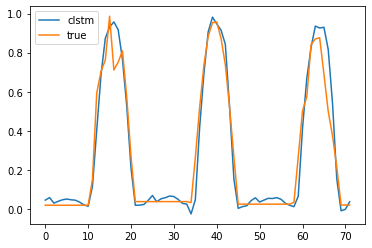

In [39]:
plt.plot(y_hat_clstm[:,0], label='clstm')
plt.plot(y_test_clstm, label='true')
plt.legend()

In [19]:
np.savetxt("resultados/arrays/clstm.txt",y_hat_clstm)

# MMFF

## Train

In [24]:
from mlopt.mlopt.omodels.MMFFBlending_Regressor import MMFFBlending

X_train_blender, y_train_blender, X_test_blender, y_test_blender = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

MMFF_model = MMFFBlending(X_train_blender, y_train_blender, X_test_blender, y_test_blender)
MMFF_model.train()
y_hat_blender = MMFF_model.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_hat_blender, y_test_blender))
print('MSE: ', mse(y_hat_blender, y_test_blender))
print('MAPE: ', MAPE(y_hat_blender, y_test_blender))

Train: (288, 23), Test: (72, 23)
Resultado Dados Teste!
MMFF
MAE:  0.03602691746221788
MSE:  0.005730215458342032
MAPE:  inf


In [28]:
pickle.dump(MMFF_model, open('resultados/best_blender_trained.pckl', 'wb'))

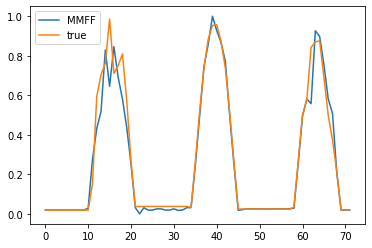

In [29]:
plt.plot(y_hat_blender, label='MMFF')
plt.plot(y_test_blender, label='true')
plt.legend()

## Results

In [31]:
MMFF_model_loaded = pickle.load(open('resultados/best_blender_trained.pckl', 'rb'))

y_hat_blender = MMFF_model_loaded.predict(X_test_blender)

print('Resultado Dados Teste!')
print('MMFF')
print('MAE: ', mae(y_test_blender, y_hat_blender))
print('MSE: ', mse(y_test_blender, y_hat_blender))
print('MAPE: ', MAPE(y_test_blender, y_hat_blender, threshold=0.1))

Resultado Dados Teste!
MMFF
MAE:  0.03602691746221788
MSE:  0.005730215458342032
MAPE:  13.764594623944998


In [32]:
np.savetxt("resultados/arrays/mmff.txt",y_hat_blender)

# NARNN - ARMAX

With neural_prophet

## Train

In [26]:
df_narnn = pd.DataFrame()
df_narnn["y"] = df_inmet['radiacao_global_wpm2']/df_inmet['radiacao_global_wpm2'].max()
df_narnn["ds"] = pd.to_datetime(df_inmet.data.astype('str') + ' ' + df_inmet.hora.astype('str')+":00:00")
df_narnn.reset_index(inplace=True, drop=True)

In [27]:
from neuralprophet import NeuralProphet

narnn_model = NeuralProphet(n_forecasts=1,n_lags=24,yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)

In [28]:
narnn_model.fit(df_narnn, freq='H')
future = narnn_model.make_future_dataframe(df_narnn, periods=0, n_historic_predictions=len(df_narnn))
df_predicted = narnn_model.predict(future)

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
2021-10-23 00:19:48,778 - NP.config - INFO - Auto-set batch_size to 16
2021-10-23 00:19:48,778: INFO - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 196
2021-10-23 00:19:48,781 - NP.config - INFO - Auto-set epochs to 196
2021-10-23 00:19:48,781: INFO - Auto-set epochs to 196
 93%|█████████▎| 224/242 [00:00<00:00, 339.25it/s]
INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.01E-02, min: 5.75E-01
2021-10-23 00:19:49,467 - NP.utils_torch - INFO - lr-range-test results: steep: 2.01E-02, min: 5.75E-01
2021-10-23 00:19:49,467: INFO - lr-range-test results: steep: 2.01E-02, min: 5.75E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.88E-01
2021-10-23 00:19:49,471 - NP.utils_torch - INFO - learning rate range test selected lr: 1.88E-01
2021-10-23 00:19:49,471: INFO - learning rate range test selected lr: 1.88E-01
Epoch[196/196]: 1

<AxesSubplot:xlabel='ds'>

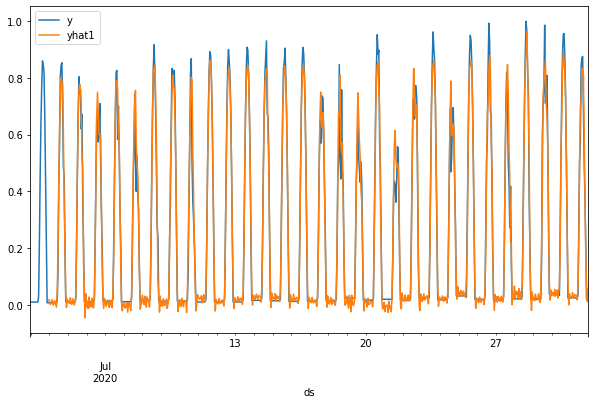

In [29]:
df_predicted.plot(x="ds", y=["y","yhat1"], figsize=(10,6))

In [30]:
pm.auto_arima(y=df_predicted["y"].iloc[24:].values.astype("float"), X=df_predicted["yhat1"].iloc[24:].values.astype("float").reshape(-1, 1),
              seasonal=False,
              maxiter=50,
              trace=True,
              max_order=30,
              n_fits=50,
              stepwise=True,
              max_d=3,
              information_criterion="aicc")

Performing stepwise search to minimize aicc
 ARIMA(2,0,2)(0,0,0)[0]             : AICC=-2066.065, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=-2074.166, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AICC=-2072.149, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AICC=-2072.149, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AICC=-2070.126, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=-2072.154, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.824 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [32]:
mod = SARIMAX(endog=df_predicted["y"].iloc[24:].values.astype("float"),
              exog=df_predicted["yhat1"].iloc[24:].values.astype("float").reshape(-1,1),
              order=(0,0,0),
              seasonal_order=(0,0,0,0))

results = mod.fit(disp=True)
y_armax_narnn = results.predict()
mape_autoarima = MAPE(df_predicted["y"].iloc[24:].values.astype("float"), y_armax_narnn, threshold=0.1)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -2074.1662057258545, Mape: 12.616221445290368


## Results

In [33]:
y_test_ = df_predicted["y"].iloc[-int(len(df_predicted)*0.2):]
y_armax_narnn_test = y_armax_narnn[-len(y_test_):]

In [34]:
print('Resultado Dados Teste!')
print('LSRM-ARMAX')
print('MAE: ', mae(y_test_, y_armax_narnn_test))
print('MSE: ', mse(y_test_, y_armax_narnn_test))
print('MAPE: ', MAPE(y_test_, y_armax_narnn_test, threshold=0.1))

Resultado Dados Teste!
LSRM-ARMAX
MAE:  0.03796130123904687
MSE:  0.003677699590103995
MAPE:  14.4352505047776


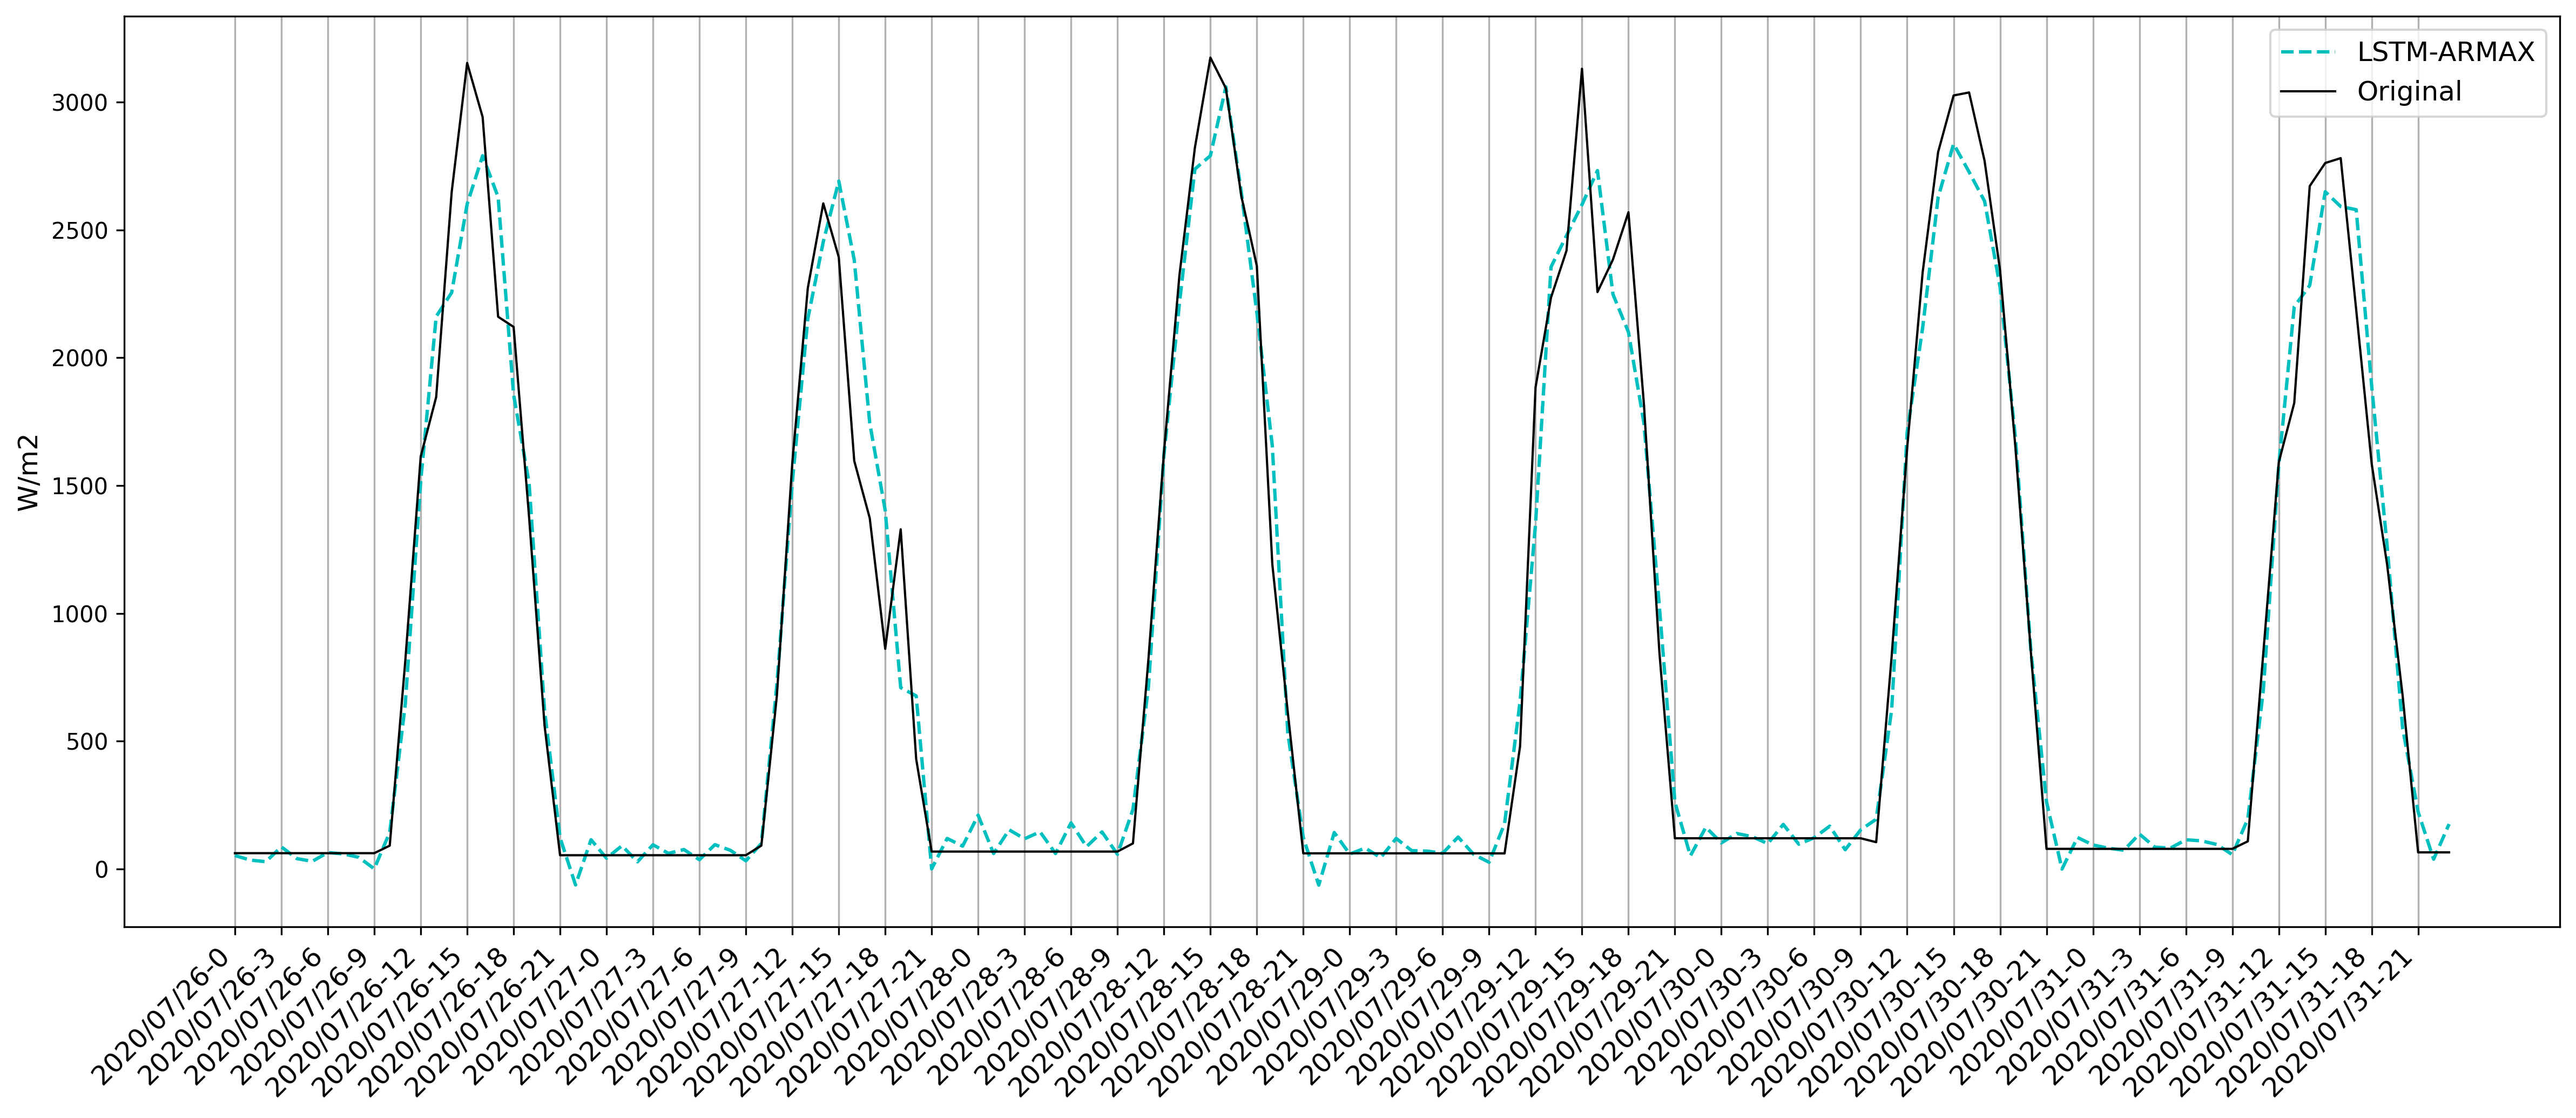

In [39]:
len_dt = len(y_test_)

fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_armax_narnn_test.reshape(-1, 1)), 'c--', label='LSTM-ARMAX')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_test_.values.reshape(-1,1)), 'k', label='Original',linewidth=1)

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/lstm_armax_test.png', dpi=300)

In [40]:
np.savetxt("resultados/arrays/narnn_armax.txt",y_armax_narnn_test[-len_dt:].reshape(-1, 1))

# Figura Unica

In [36]:
y_hat_blender = np.loadtxt("./resultados/arrays/mmff.txt")
y_hat_clstm = np.loadtxt("./resultados/arrays/clstm.txt")
y_hat_lstm = np.loadtxt("./resultados/arrays/lstm.txt")
y_hat_armax_narnn = np.loadtxt("./resultados/arrays/narnn_armax.txt")
y_hat_agmlp_residual = np.loadtxt("./resultados/arrays/agmlp_residual.txt")
y_hat_agmlp_en_residual=np.loadtxt("./resultados/arrays/agmlp_ensemble_residual.txt")

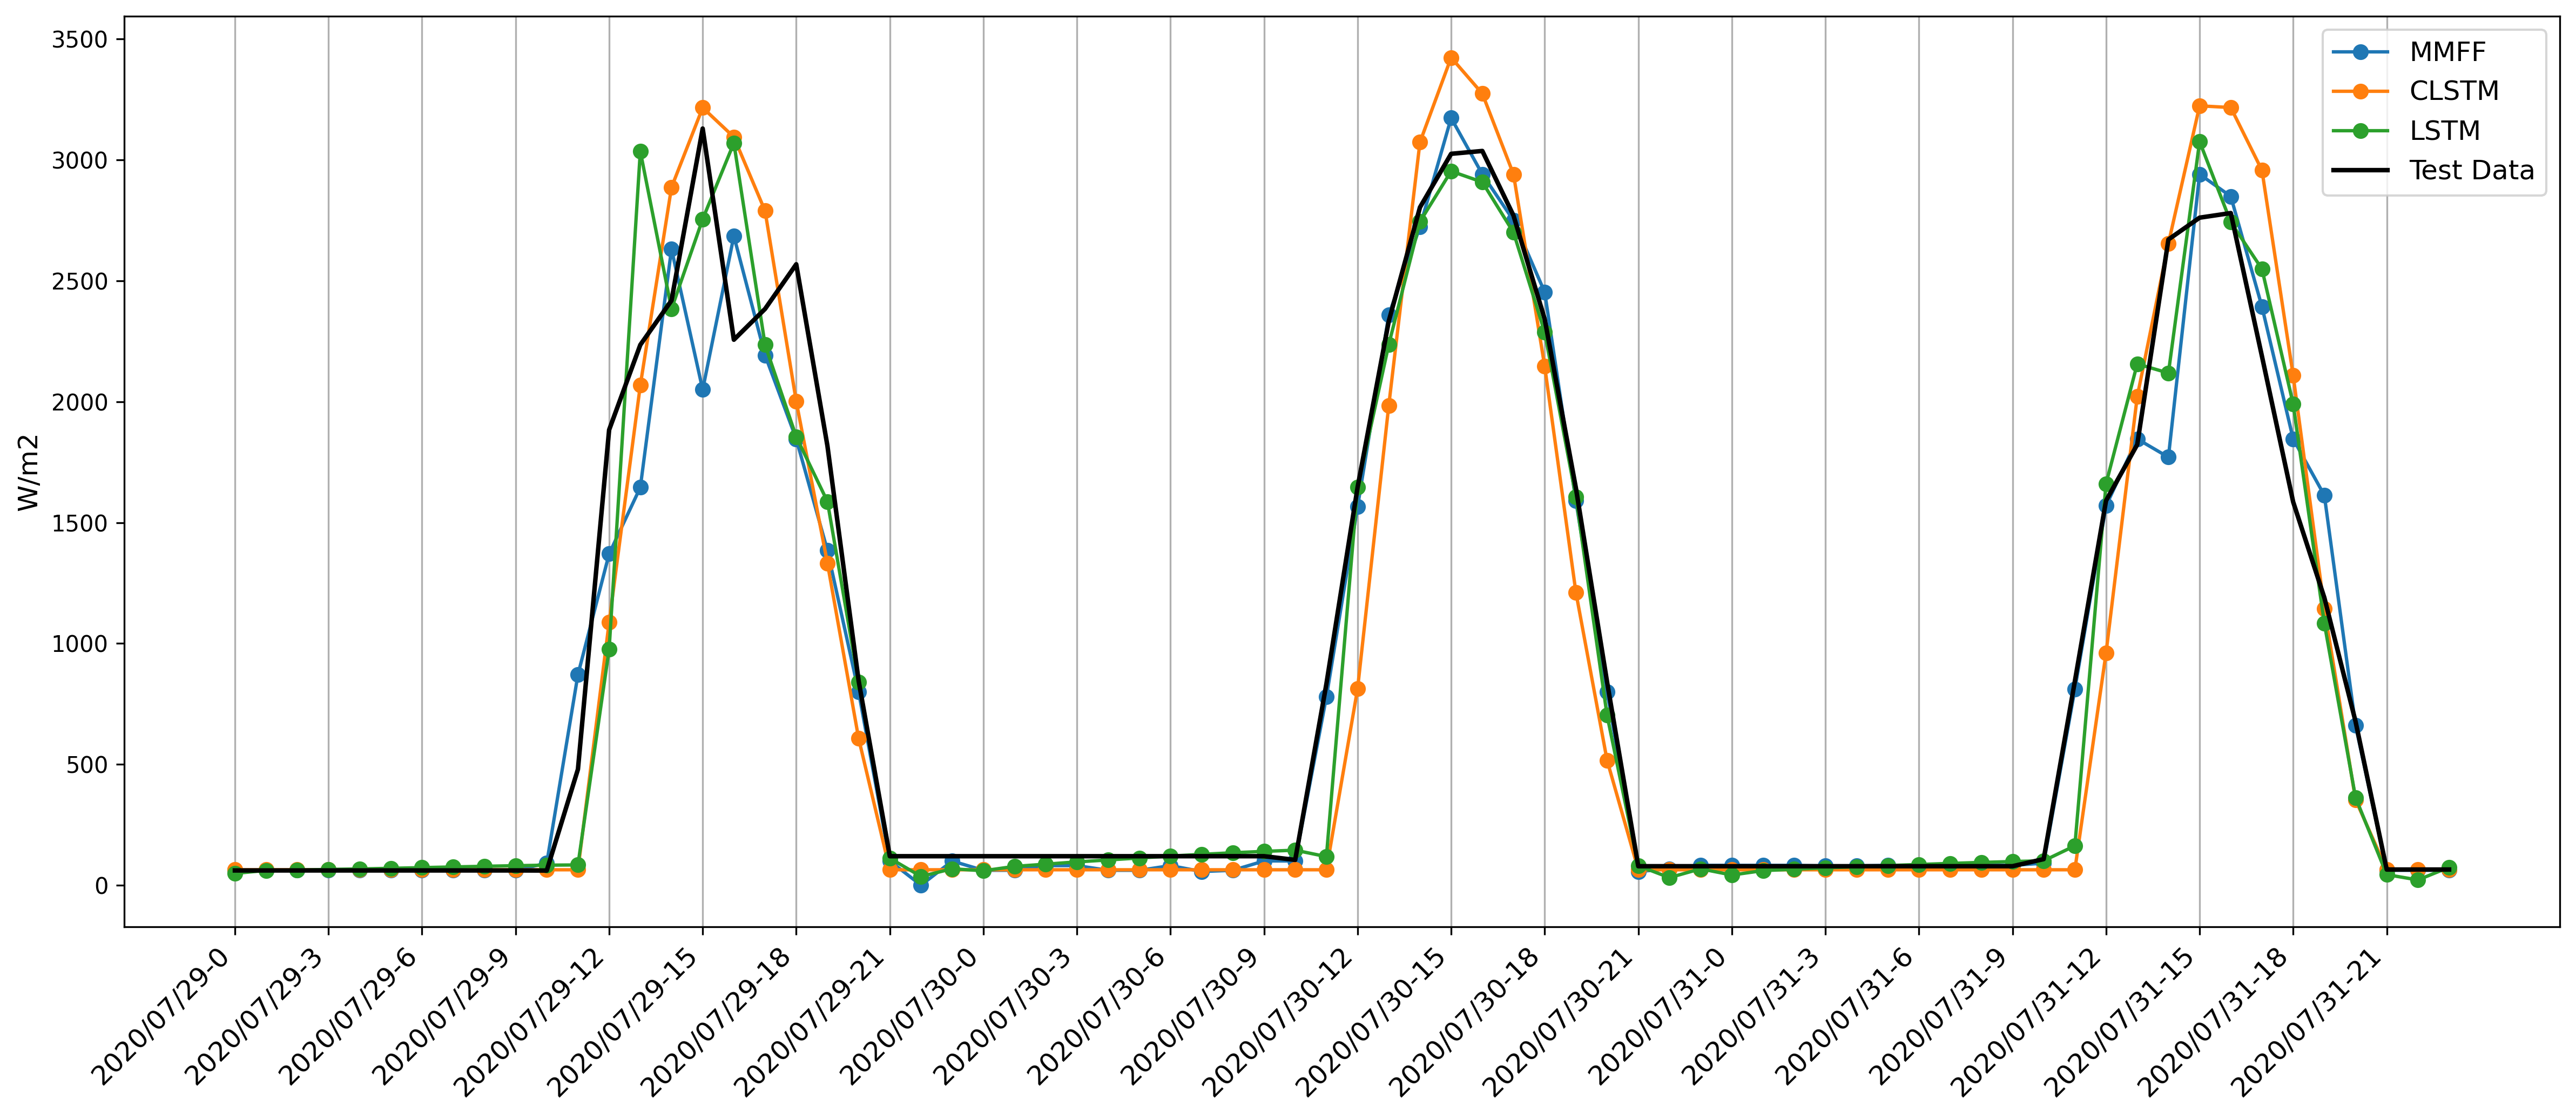

In [45]:
fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_blender[-len_dt:].reshape(-1, 1)), '-o', label='MMFF')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), '-o', label='CLSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), '-o', label='LSTM')
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_armax_narnn_test[-len_dt:].reshape(-1, 1)),'-o',label='NARNN-ARMAX')
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_agmlp_residual[-len_dt:].reshape(-1, 1)), '-o', label='AG-MLP')
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_agmlp_en_residual[-len_dt:].reshape(-1, 1)),'-o',label='AG-MLP-EN')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Test Data',linewidth=2)
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), '--', label='SARIMAX')

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids_test_part1.png', dpi=300)

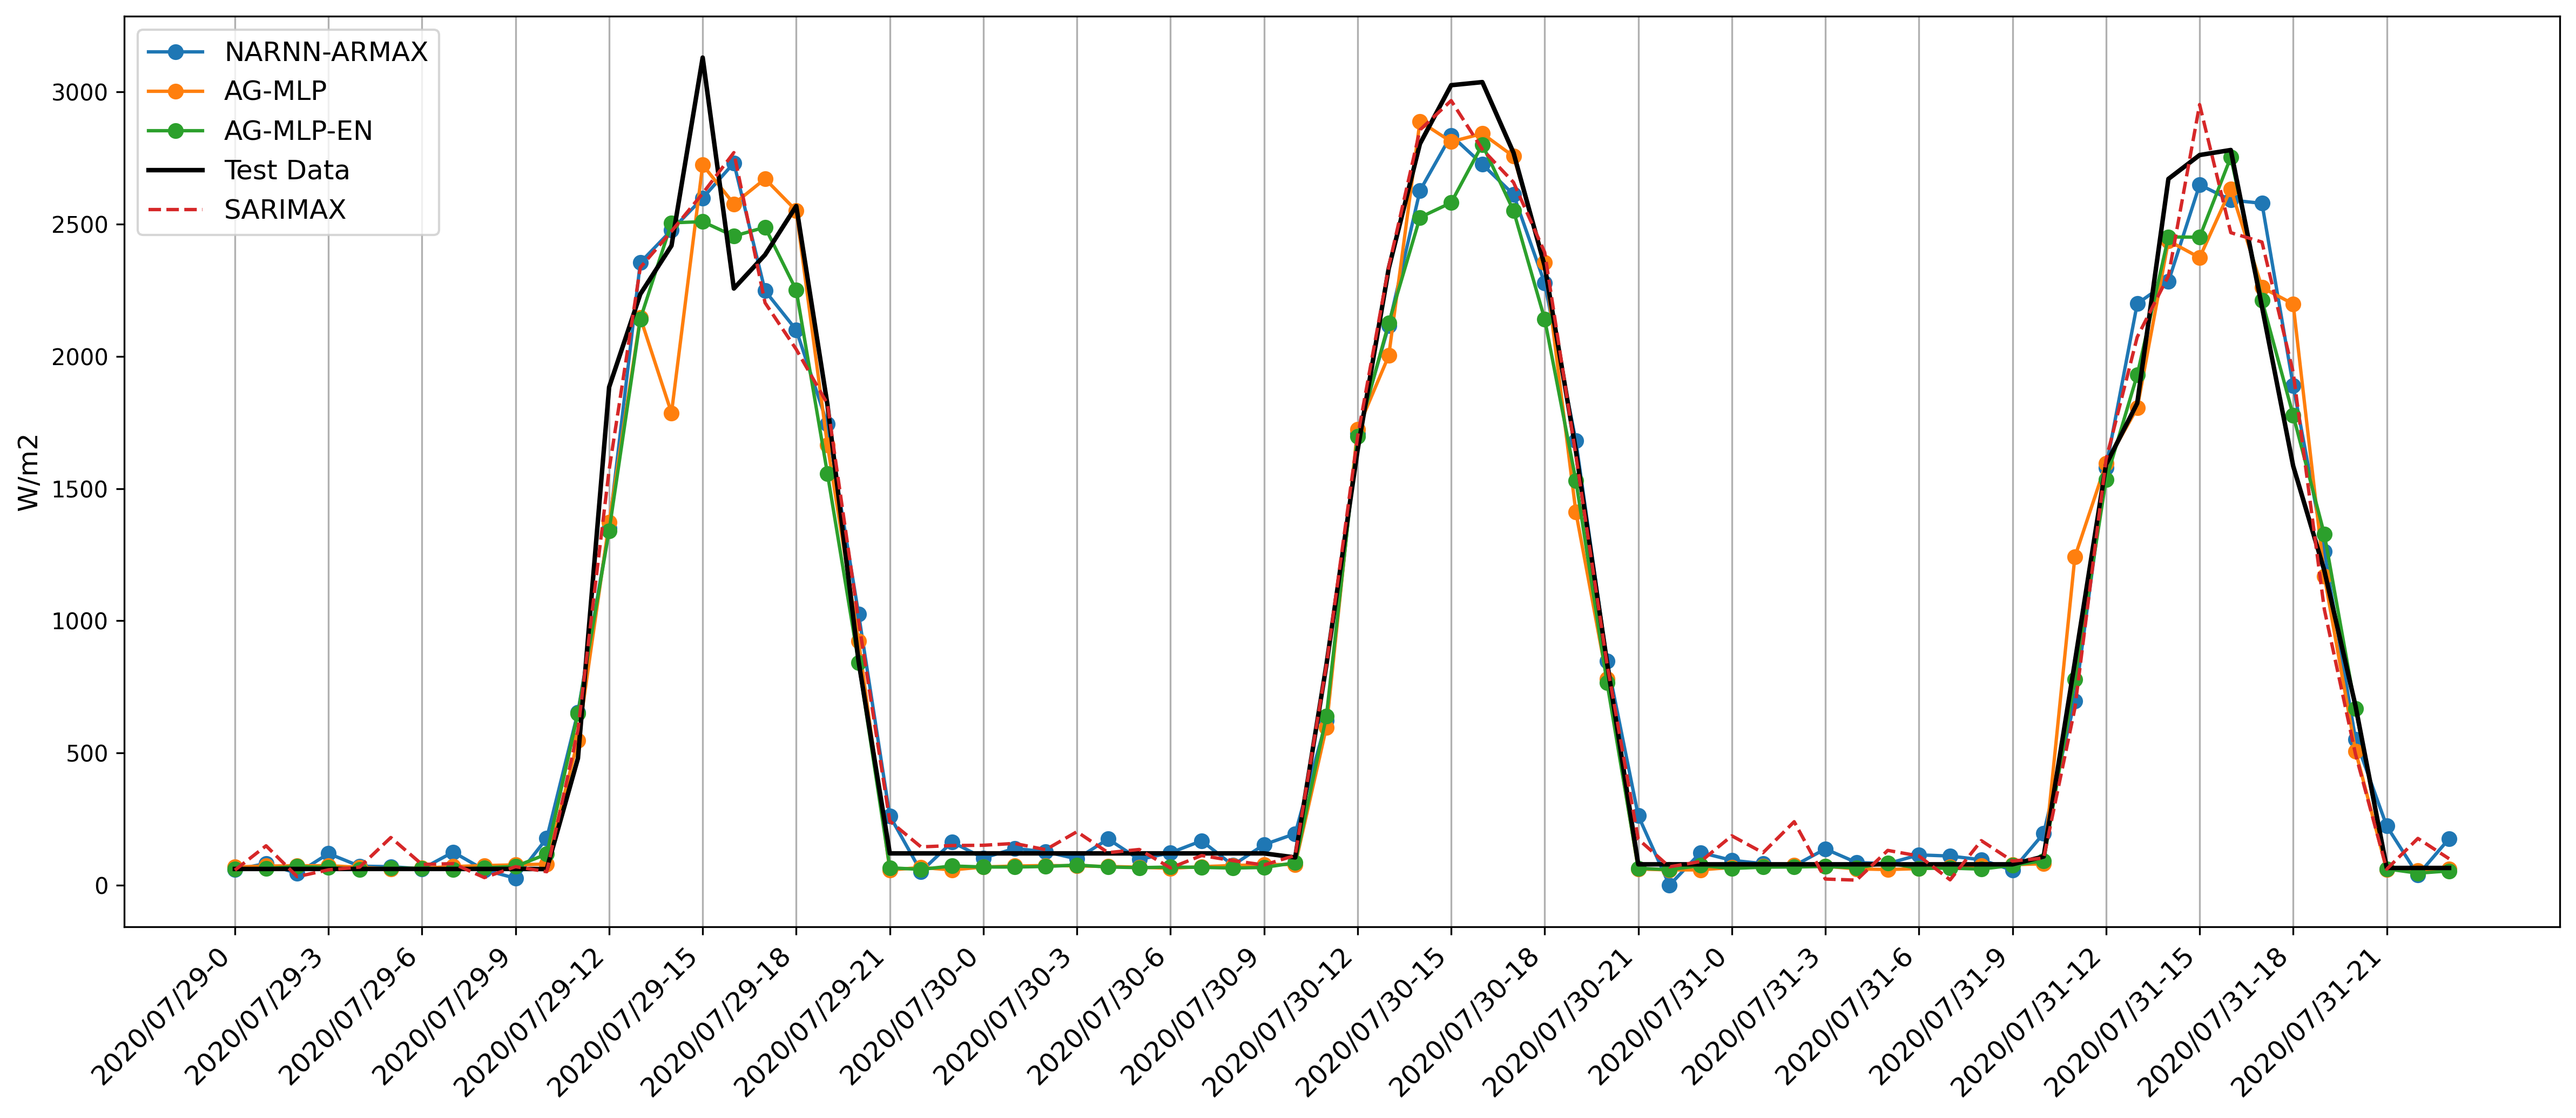

In [46]:
fig, ax = plt.subplots(1,1, figsize=(16,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_blender[-len_dt:].reshape(-1, 1)), '-o', label='MMFF')
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_clstm[-len_dt:].reshape(-1, 1)), '-o', label='CLSTM')
# ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_lstm[-len_dt:].reshape(-1, 1)), '-o', label='LSTM')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_armax_narnn_test[-len_dt:].reshape(-1, 1)),'-o',label='NARNN-ARMAX')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_agmlp_residual[-len_dt:].reshape(-1, 1)), '-o', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_hat_agmlp_en_residual[-len_dt:].reshape(-1, 1)),'-o',label='AG-MLP-EN')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'k', label='Test Data',linewidth=2)
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), '--', label='SARIMAX')

plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids_test_part2.png', dpi=300)